This notebook demonstrates the task of image classification, in this case a classification of: vortex and no vortex presence. The notebook includes the fine-tuning (training phase), testing and inference on a dataset of satellite images containing waterbodies in Angola. The fine-tuning is performed on a pre-trained CNN.

 The notebook follows these steps:

*   General setup of DL environment in Google Colab (coupled to your Google Drive)
*   All settings
*   Fine-tuning the model with a training dataset
*   Testing the fine-tuned model
*   Inference: classification of vortices




# General setup

In [37]:
!pip install --upgrade geopandas

# Imports
import pathlib
import numpy as np
import os
import sys
import datetime
import itertools
import tensorflow_hub as hub
import pandas as pd
import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow import keras
import tf_keras as keras
from tf_keras import layers

import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import geopandas as gpd
from sklearn.metrics import confusion_matrix, accuracy_score

!git clone https://github.com/Argantonio65/OpticalMeasurements.git

print(tf.__version__)

fatal: destination path 'OpticalMeasurements' already exists and is not an empty directory.
2.17.0


In [19]:
# The following line of code is a shell command executed within the notebook. It uses the '!' prefix to run a command as if it were in the terminal.
!nvidia-smi

# The 'nvidia-smi' command stands for NVIDIA System Management Interface. It is used to query and manage NVIDIA GPU devices.
# Running this command displays information about the GPUs on your system, including utilization, memory usage, driver version, and more.

Thu Sep 19 15:00:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              49W / 350W |   1449MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [20]:
from google.colab import auth
auth.authenticate_user()

In [21]:
!gcloud config set project deepscale-11210295-013

Updated property [core/project].


In [22]:
!mkdir -p /content/dataset/
!gsutil -m cp -r gs://classification_example/dataset_vortexBinary_v0/* /content/dataset/

Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1001.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1011.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1021.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1031.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1041.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1061.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1101.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1131.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1121.png...
Copying gs://classi

In [26]:
# Set the AUTOTUNE option for automatic optimization and print the Tensorflow version
AUTO = tf.data.experimental.AUTOTUNE
print(f"Tensorflow version that is currently being used: {tf.__version__}")

Tensorflow version that is currently being used: 2.17.0


In [27]:
# Initialize TPU if data is stored in the cloud
tpu = None

if tpu:
  # If TPU is initialized, shut down the TPU system
  tf.tpu.experimental.shutdown_tpu_system(tpu)

try:
  # Attempt to detect and initialize a TPU
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
  # If no TPU is found, fall back to default strategy for CPU or single GPU
  strategy = tf.distribute.get_strategy() # default strategy for CPU and single GPU

# Settings

#### Paths and files

In [28]:
# Google Drive directory that stores the downloaded data and scripts (later changeo to name repository folder: image_classification)
dir_gdrive = r'/content/'

# Datasets, model and scripts
dir_data = f'{dir_gdrive}/dataset'
dir_model = f'{dir_gdrive}/01_model'
dir_scripts = f'{dir_gdrive}/02_src'
sys.path.append(dir_scripts)

# Print system path
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content//02_src',
 '/content//02_src',
 '/content//02_src']

#### Model (pre-trained CNN)

In [29]:
model_name = "efficientnetv2-xl-21k"
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"



#### Training

In [65]:
normalization_layer = tf.keras.layers.Rescaling(1.5 / 255)
do_data_augmentation = True

IMAGE_SIZE = (512, 512) # this is the image shape required for the keras model (or what): so if the images have different shapes (that is the case for the vortex images. TODO: the images need to be reshaped to (512, 512); there is a keras function for this)
BATCH_SIZE = 50        # TODO: check with Antonio: he used batch size 20 for the testing and inference
EPOCHS = 30

drop_out_rate = 0.3
learning_rate = 0.005
momentum = 0.9
label_smoothing = 0.1
metrics = ['accuracy']


# Fine-tune model

## Training

### Build dataset

In [59]:
def extract_labels(dataset):
    labels = []
    for _, label in tqdm(dataset):
        labels.append(label.numpy())
    return np.concatenate(labels, axis=0)

def build_training_dataset(dir_data, subset, image_size, batch_size):
  ds = tf.keras.preprocessing.image_dataset_from_directory( #write: expects data in specific format (folder names)
      dir_data,
      validation_split=.30,
      subset=subset,
      label_mode="categorical",
      seed=123,
      image_size=image_size,
      batch_size=1)

  # Extract labels from the training dataset (useful to created balancing weights)
  labels = extract_labels(ds)

  ds_class_names = tuple(ds.class_names)
  ds_size = ds.cardinality().numpy()
  ds = ds.unbatch().batch(batch_size)
  if subset == "training":
    ds = ds.repeat()
  return ds, ds_class_names, ds_size, labels

def augment_data(do_data_augmentation, preprocessing_model):

  if do_data_augmentation:
    # preprocessing_model.add(
    #     tf.keras.layers.RandomRotation(40))
    preprocessing_model.add(
        tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
        tf.keras.layers.RandomFlip(mode="horizontal"))
    # preprocessing_model.add(
    #     tf.keras.layers.RandomFlip(mode="vertical"))
  return preprocessing_model

In [62]:
# Training data
dir_data_training = dir_data
ds_train_r, class_names, ds_train_size, train_labels = build_training_dataset(dir_data_training, "training", IMAGE_SIZE, BATCH_SIZE)
preprocessing_model = tf.keras.Sequential([normalization_layer])
preprocessing_model = augment_data(do_data_augmentation, preprocessing_model)
ds_train = ds_train_r.map(lambda images, labels:(preprocessing_model(images), labels))

# Validation data
ds_val, class_names, ds_val_size, _ = build_training_dataset(dir_data_training, "validation", IMAGE_SIZE, BATCH_SIZE)
ds_val = ds_val.map(lambda images, labels:(normalization_layer(images), labels))

Found 271 files belonging to 2 classes.
Using 190 files for training.


100%|██████████| 190/190 [00:01<00:00, 119.60it/s]


Found 271 files belonging to 2 classes.
Using 81 files for validation.


100%|██████████| 81/81 [00:00<00:00, 113.36it/s]


In [63]:
### CREATE A class weights dictionary to deal with imbalanced datasets

from sklearn.utils import class_weight

y_values = np.argmax(train_labels, axis = 1) # train labels are supplied as [[0,1], [1,0], [1,0]...] where the index of one indicates the class. argmax resuls in the label index vector [0,1,1...]

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(y_values), y=y_values)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [66]:
def plot_training_data(ds, number_of_images):
  ncols = 4
  nrows = number_of_images // ncols + 1
  fig = plt.figure(figsize=(15, 15))
  for images, labels in ds.take(1):
    for i in range(number_of_images):
      plt.subplot(nrows, ncols, i + 1)
      plt.imshow(images[i].numpy())
      plt.title(np.argmax(labels[i].numpy()))
      plt.axis("off")
  return fig

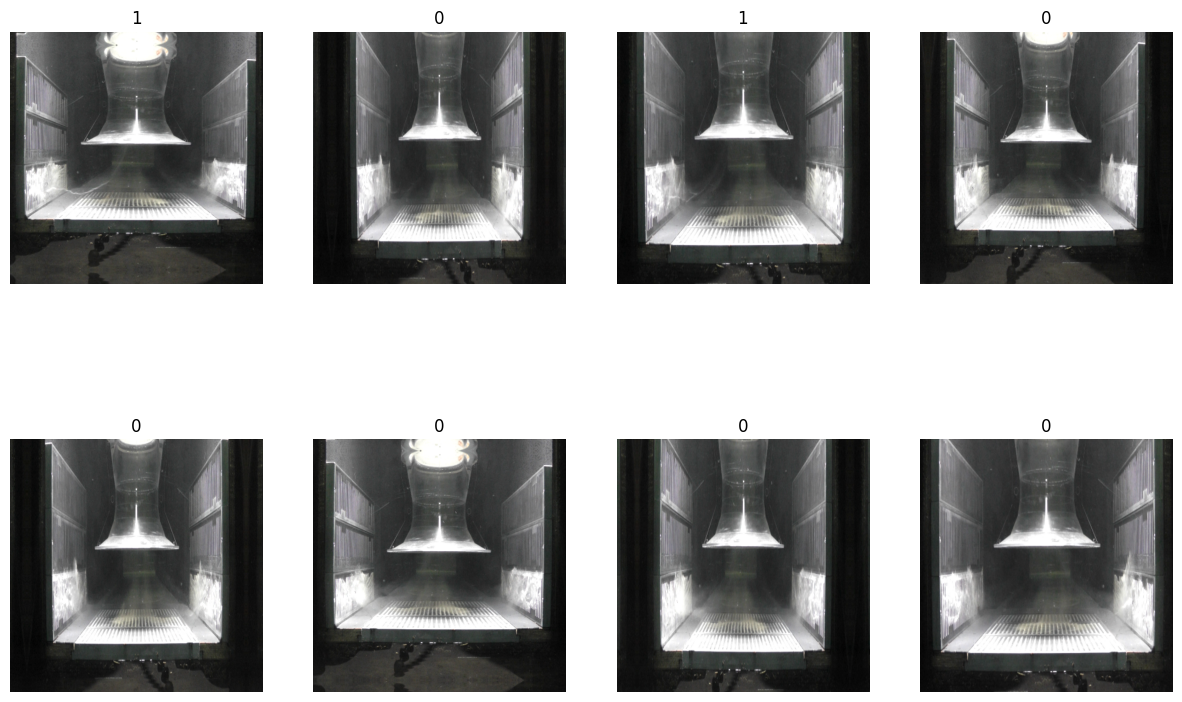

In [35]:
# Plot a few images from the validation dataset to check
fig_val = plot_training_data(ds_train, 8)

### Build model

In [67]:
# Composition of the model of different layers (input layer, original encoder layers, dense layers that are trained with the satellite imagery dataset)
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    keras.layers.Dropout(rate=drop_out_rate),
    keras.layers.Dense(len(class_names),
    kernel_regularizer=keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

# Configure the model for training by specifiying the optimizer (Stochastic Gradient Descent), loss function and metrics to be used
model.compile(
  optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
  loss=keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=label_smoothing),
  metrics=metrics)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              207615832 
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 207618394 (792.00 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 207615832 (791.99 MB)
_________________________________________________________________


### Train model

In [72]:
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                         min_delta=0.001,
                                         verbose=1,
                                         patience=3,
                                         restore_best_weights=False)

#,
    # class_weight=class_weights_dict

hist = model.fit(
    ds_train,
    epochs=EPOCHS,
    # callbacks=[callback],
    steps_per_epoch=ds_train_size // BATCH_SIZE,
    validation_data=ds_val,
    validation_steps=ds_val_size // BATCH_SIZE).history

Epoch 1/30
3/3 [==============================] - 3s 1s/step - loss: 0.6318 - accuracy: 0.7667 - val_loss: 0.4143 - val_accuracy: 0.9500
Epoch 2/30
3/3 [==============================] - 3s 1s/step - loss: 0.7130 - accuracy: 0.6833 - val_loss: 0.2726 - val_accuracy: 0.9500
Epoch 3/30
3/3 [==============================] - 3s 1s/step - loss: 0.4888 - accuracy: 0.8000 - val_loss: 0.2553 - val_accuracy: 0.9500
Epoch 4/30
3/3 [==============================] - 2s 961ms/step - loss: 0.5392 - accuracy: 0.8200 - val_loss: 0.4381 - val_accuracy: 0.9000
Epoch 5/30
3/3 [==============================] - 3s 1s/step - loss: 0.7907 - accuracy: 0.6333 - val_loss: 0.8609 - val_accuracy: 0.3000
Epoch 6/30
3/3 [==============================] - 3s 1s/step - loss: 0.7664 - accuracy: 0.6000 - val_loss: 0.4337 - val_accuracy: 0.9500
Epoch 7/30
3/3 [==============================] - 2s 916ms/step - loss: 0.6354 - accuracy: 0.8600 - val_loss: 0.3813 - val_accuracy: 0.9000
Epoch 8/30
3/3 [===================

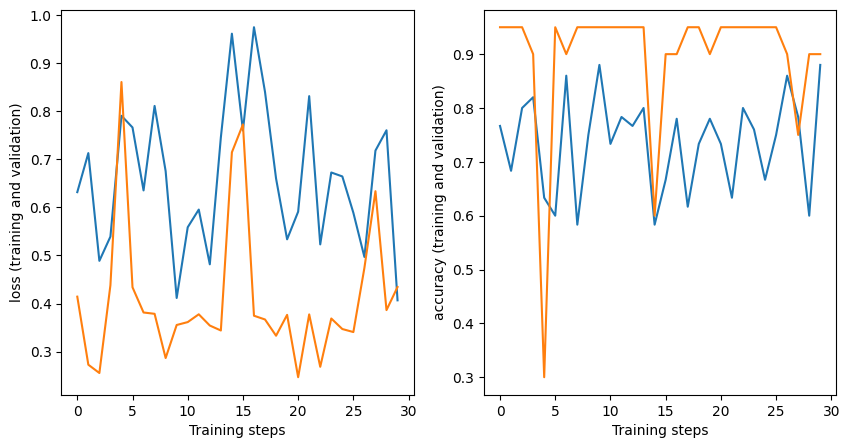

In [73]:
def plot_training_results(hist):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    for i, x in enumerate(['loss', 'accuracy']):
        axes[i].set_ylabel(f'{x} (training and validation)')
        axes[i].set_xlabel("Training steps")
        axes[i].plot(hist[x])
        axes[i].plot(hist[f'val_{x}'])
    # axes[0].set_ylim([0,1])
    # axes[1].set_ylim([0,2])
    return fig

fig = plot_training_results(hist)

In [74]:
def save_model(model, dir_model, name_model, hist):
    full_path_model = os.path.join(dir_model, f'model_{name_model}_finetuned.keras')
    model.save(full_path_model)
    hist_df = pd.DataFrame(hist)
    hist_df.to_csv(os.path.join(dir_model, f'hist_{name_model}_finetuned.csv'))
    return  print(f'Your fine-tuned model is saved as: {full_path_model}')

save_model(model, dir_model, model_name, hist)

FileNotFoundError: [Errno 2] No such file or directory: '/content//01_model/model_efficientnetv2-xl-21k_finetuned.keras'

## Testing

### Build dataset

In [45]:
# dir_data_testing = os.path.join(dir_data, 'testing') # dir_data_testing = f'{dir_gdrive}/testing3class'

# # ds_test = tf.keras.utils.image_dataset_from_directory(
# #     dir_data_testing,
# #     image_size=IMAGE_SIZE,
# #     batch_size=BATCH_SIZE, #25?
# #     shuffle = True
# # )

# ds_test = ds_test.map(lambda images, labels:(normalization_layer(images), labels))

ds_test = ds_val ## just use validation for now

### Test model

In [ ]:
# Load fine-tuned model
# model = keras.models.load_model(os.path.join(dir_model, f'{model_name}_finetuned.h5'),
#        custom_objects={'KerasLayer':hub.KerasLayer})
model = keras.models.load_model(r'/content/01_model/model_efficientnetv2-xl-21k_finetuned.h5',
       custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
import sys
sys.path.append('/content/OpticalMeasurements/ComputerVision/examples/image_classification/00_src/testing.py')

In [ ]:
!pwd

/content


In [ ]:
%load '/content/OpticalMeasurements/ComputerVision/examples/image_classification/00_src/testing.py'

In [ ]:
py_file_location = "/content/OpticalMeasurements/ComputerVision/examples/image_classification/00_src"
sys.path.append(os.path.abspath(py_file_location))

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score
# from testing import test_model
def test_model(model, ds):
    labels_test = []
    predictions_test = []
    for images, labels in ds:
        batch_predictions = model.predict(images)
        labels_test.extend(labels)
        predictions_test.extend(np.argmax(batch_predictions, axis=1))

    return labels_test, predictions_test

labels_test, predictions_test = test_model(model, ds_test)

acc = accuracy_score(np.argmax(labels_test, axis = 1), predictions_test)
cm = confusion_matrix(np.argmax(labels_test, axis = 1), predictions_test)

print(f"Accuracy: {acc}")
print(f"Confusion matrix: \n{cm}")

1/1 [==============================] - 0s 86ms/step
Accuracy: 0.8518518518518519
Confusion matrix: 
[[46  0]
 [ 8  0]]


1/1 [==============================] - 0s 167ms/step


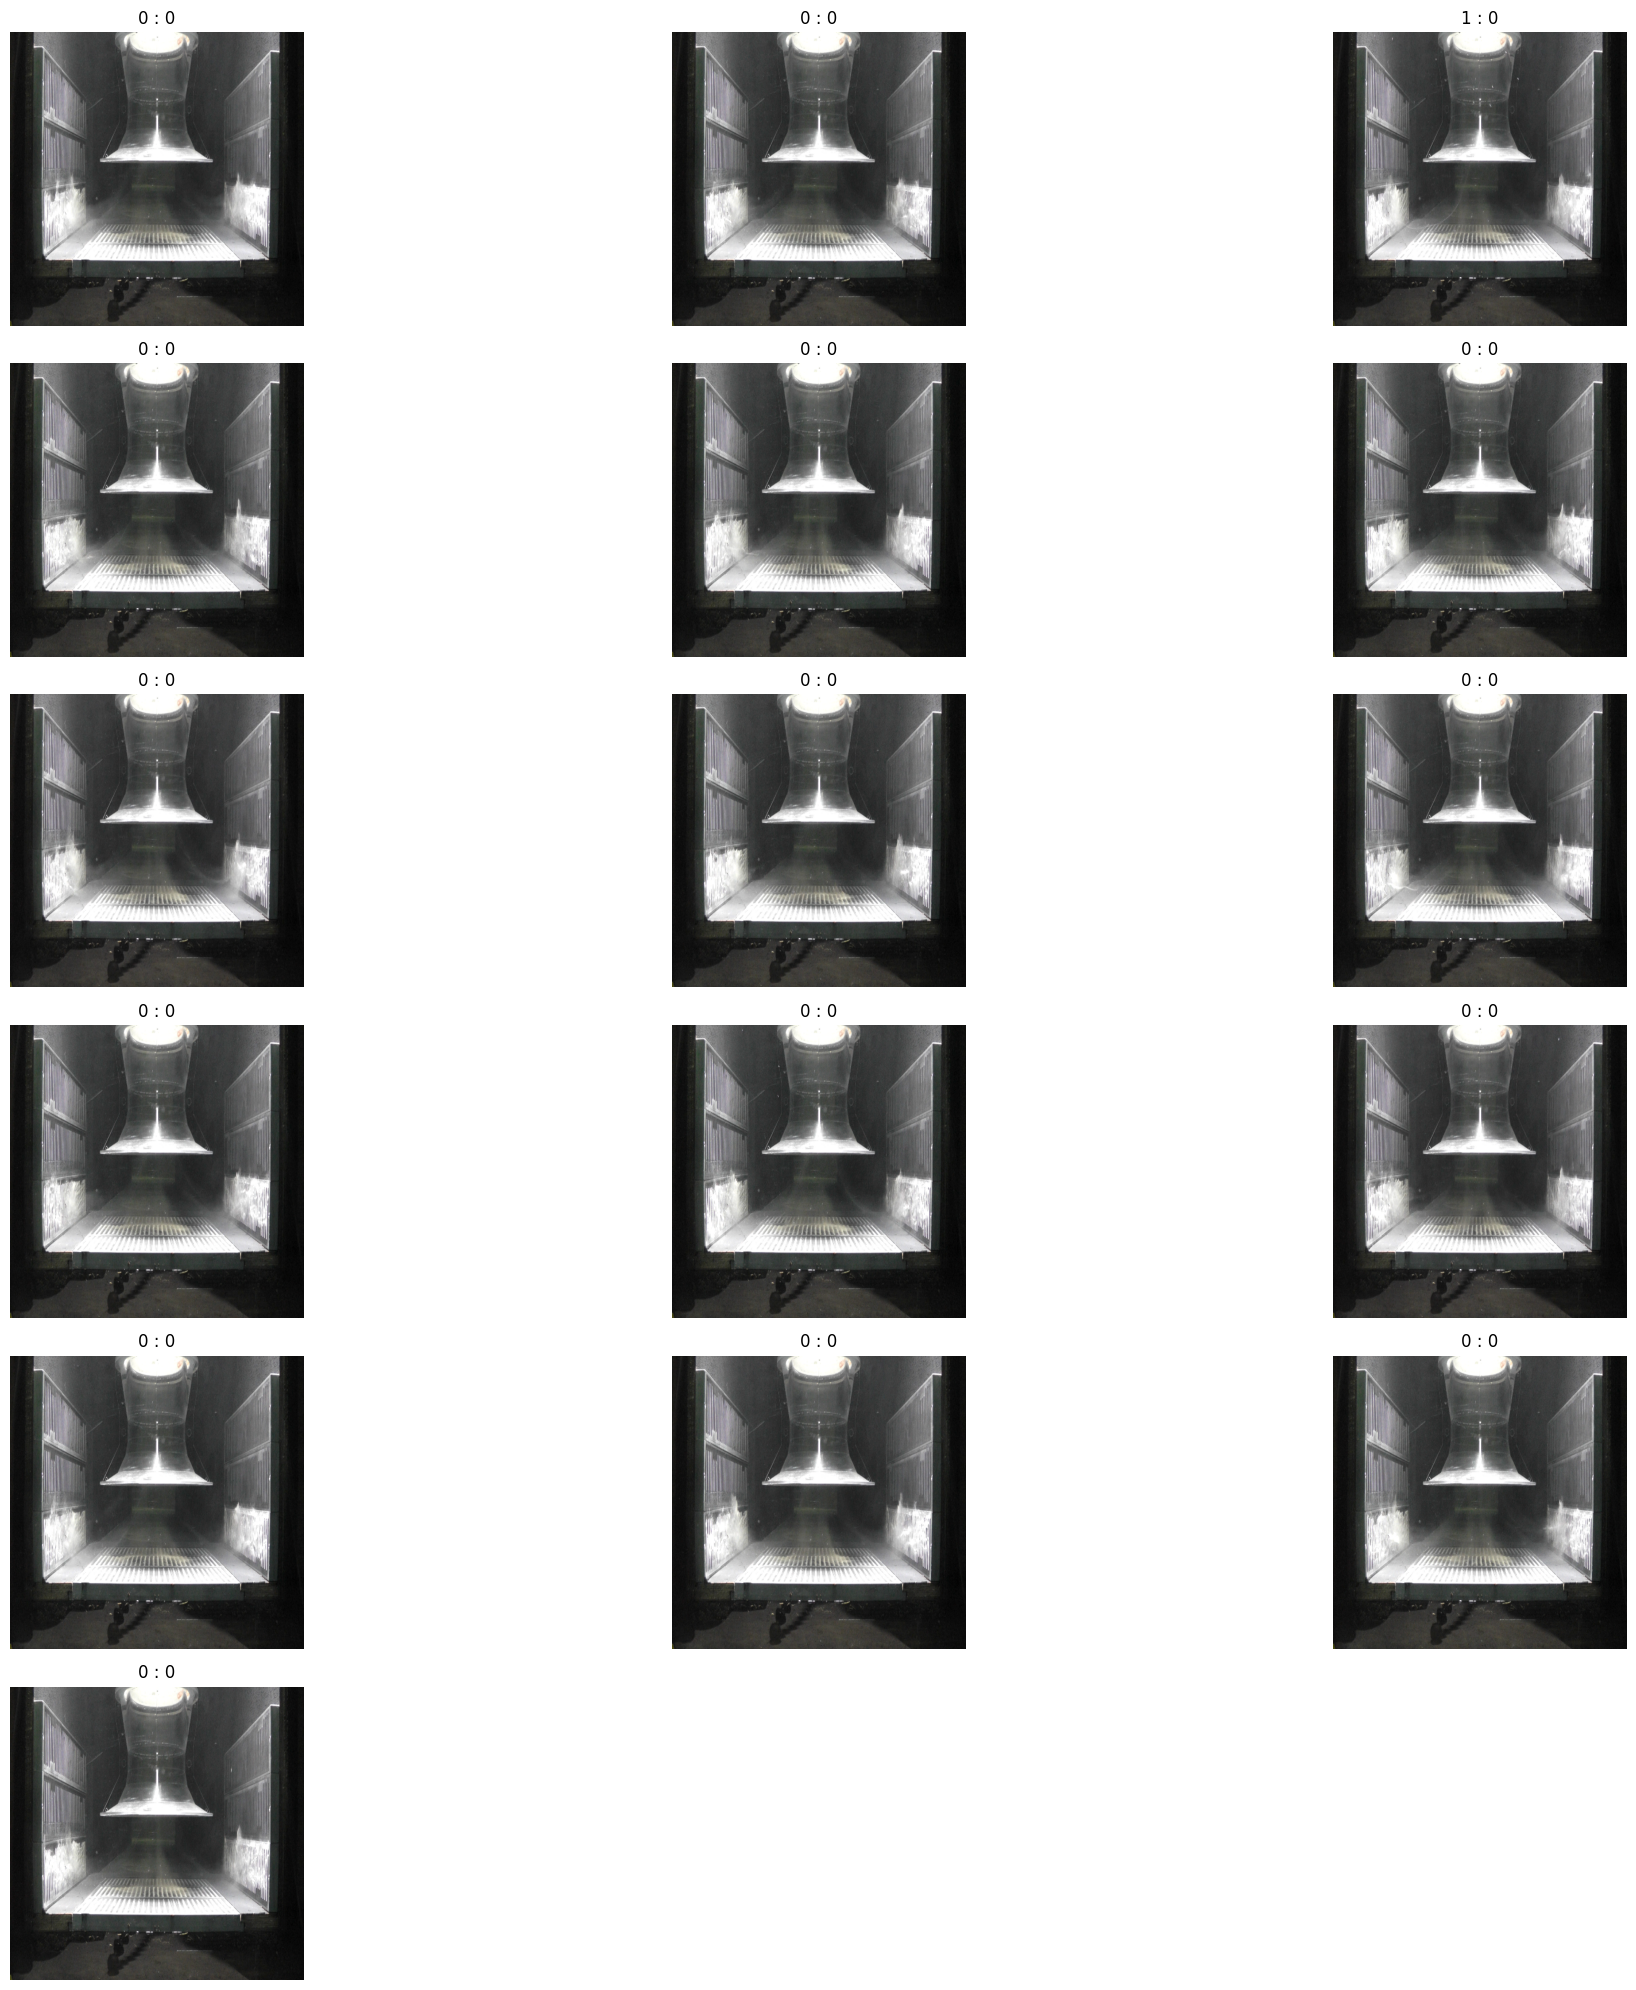

In [76]:
def plot_test_data(model, ds, number_of_images):
  ncols = 3
  nrows = number_of_images // ncols + 1
  fig = plt.figure(figsize=(20, 20))
  for images, labels in ds.take(1):
      batch_predictions = model.predict(images)
      labels_test.extend(labels)
      predictions_test.extend(np.argmax(batch_predictions, axis=1))
      for i in range(number_of_images):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f'{np.argmax(labels[i].numpy())} : {predictions_test[i]}')
        plt.axis("off")
  fig.tight_layout()
  return fig

fig = plot_test_data(model, ds_test, 16)

In [47]:
from plot import plot_test_results

fig = plot_test_results(model, ds_test)

ModuleNotFoundError: No module named 'plot'

# Inference

### Build dataset

In [ ]:
from inference import get_img_ids

dir_data_inference = os.path.join(dir_data, 'inference') # dir_data_inference = f'{dir_gdrive}/AngolaPNGsZoom'

ds_inf = tf.keras.utils.image_dataset_from_directory(
    dir_data_inference,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, #20?
    shuffle = False,
    label_mode=None,
    labels=None)

img_ids = get_img_ids(ds_inf)

ds_inf = ds_inf.map(lambda images:(normalization_layer(images)))

### Inference

In [ ]:
predictions = model.predict(dataset)
y_pred = np.argmax(predictions, axis = 1)

In [ ]:
# Show some results of the inference
from inference import plot_inference_results

fig = plot_inference_results(model, ds_inf)

In [ ]:
# Link the waterbodies in the images to the coordinates of the blobs in the geojson file and save to a new geojson file
from inference import link_waterbodies_coordinates, save_prediction_geojson

data_coord = gpd.read_file(os.path.join(dir_data, f'{filename_geojson}.geojson'))
pred_coord = linke_waterbodies_coordinates(img_ids, y_pred, data_coord)
save_prediction_geojson(pred_coord, dir_data, filename_geojson)